In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from metpy import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import fsspec
import os

In [2]:
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:35047 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 32.00 GiB


In [3]:
connection_string = os.getenv('azure_connection_string')

In [4]:
fs_out = fsspec.get_mapper('az://goes-zarr/test.zarr/', connection_string=connection_string)


In [5]:
%time ds = xr.open_zarr(fs_out)

CPU times: user 11.8 s, sys: 551 ms, total: 12.4 s
Wall time: 27.2 s


## Lat/lon

In [6]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [7]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [8]:
ds = calc_latlon(ds)

/tmp/ipykernel_3108/2211100413.py:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [9]:
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

In [10]:
%%time
subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))

CPU times: user 18.3 ms, sys: 3.7 ms, total: 22 ms
Wall time: 20.3 ms


### Calculate true color
https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html

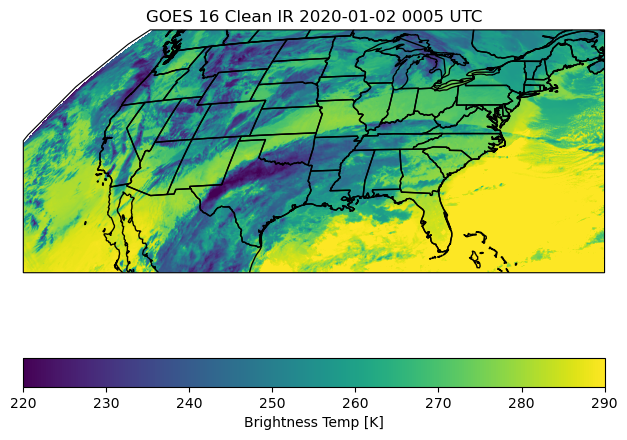

In [11]:
nt = len(subset.t)

from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(7.5,7.5), dpi=100)

dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y
ax = fig.add_subplot(111, projection = dummy_channel.metpy.cartopy_crs)

p = ax.imshow(subset.CMI_C13.isel(t=0), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
         vmin=220, vmax=290)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)
ax.add_feature(ccrs.cartopy.feature.STATES)

ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")
ax.set_title(f"GOES 16 Clean IR {ts}")
plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


def update_anim(i):
    ts = pd.to_datetime(str(subset.t[i].values)).strftime("%Y-%m-%d %H%M UTC")
    
    ax.clear()
    
    p = ax.imshow(subset.CMI_C13.isel(t=i), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
                 vmin=220, vmax=290)
    ax.set_title(f"GOES 16 Clean IR {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
#     plt.colorbar(p, orientation='horizontal', label='Brightness Temperature [K]', ax=ax)
    

    return p
  
# update_anim(1)
animator = FuncAnimation(fig, update_anim, frames=nt, interval=50)
# plt.show()


In [12]:
%time HTML(animator.to_html5_video())

CPU times: user 1min 10s, sys: 4.55 s, total: 1min 14s
Wall time: 2min 53s


# Make a veggie-color image of the East Coast using GOES-17 (east) data

CPU times: user 11.9 s, sys: 4.39 s, total: 16.3 s
Wall time: 41.3 s


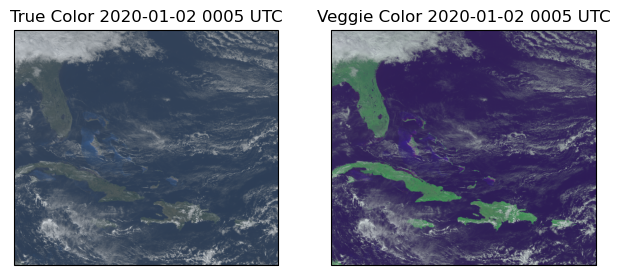

In [13]:
%%time
top = 35 # north lat
left = -84 # west long
right = -64 # east long
bottom =  15 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))
subset

nt = len(subset.t)

#from matplotlib.animation import FuncAnimation


dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y

# https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html
# Load the three channels into appropriate R, G, and B variables
#removed .data here, not necessary & actually a little nicer to keep metadata attached
R = subset['CMI_C02']#.data  
G = subset['CMI_C03']#.data
B = subset['CMI_C01']#.data
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)
# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

Rr,Gr,G_truer,Br=R.isel(t=110),G.isel(t=110),G_true.isel(t=110),B.isel(t=110)

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([Rr, Gr, Br])
# The RGB array for the true color image
RGB = np.dstack([Rr, G_truer, Br])

#p = ax.imshow(RGB_veggie, origin='upper', extent=(x.min(), x.max(), y.min(), y.max())) #,vmin=220, vmax=290)
fig = plt.figure(figsize=(7.5,7.5), dpi=100)
for ifig in range(121,123):
    ax = fig.add_subplot(ifig, projection = dummy_channel.metpy.cartopy_crs)
    if ifig==121:
        p = ax.imshow(RGB, origin='upper', vmin=0, vmax=1)
        ax.set_title(f"True Color {ts}")
    if ifig==122:
        p = ax.imshow(RGB_veggie, origin='upper', vmin=0, vmax=1)
        ax.set_title(f"Veggie Color {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
    ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")

#plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


CPU times: user 1.32 s, sys: 151 ms, total: 1.47 s
Wall time: 10.1 s


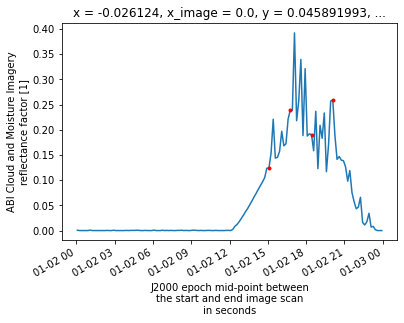

In [14]:
%%time
#plot time series and value of a few points
iy,ix=-10,10
subset.CMI_C05[:,iy,ix].plot()
for it in [90,100,110,120]:
    plt.plot(subset.t[it],subset.CMI_C05[it,iy,ix],'r.')

CPU times: user 163 ms, sys: 0 ns, total: 163 ms
Wall time: 152 ms


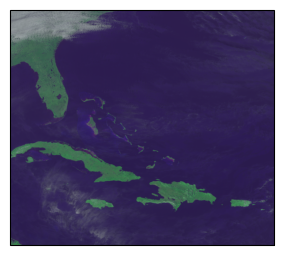

In [15]:
%%time
#try to remove most clouds by looking at daytime min
Rsubset = R.isel(t=slice(90,120))
imax = Rsubset.argmin(dim='t')+90
Rr,Gr,G_truer,Br=R.isel(t=imax),G.isel(t=imax),G_true.isel(t=imax),B.isel(t=imax)
# The RGB array with the raw veggie band
RGB_veggie = np.dstack([Rr, Gr, Br])
fig = plt.figure(figsize=(7.5,7.5), dpi=100)
ax = fig.add_subplot(ifig, projection = dummy_channel.metpy.cartopy_crs)
p = ax.imshow(RGB_veggie, origin='upper')

CPU times: user 105 ms, sys: 7.8 ms, total: 113 ms
Wall time: 153 ms


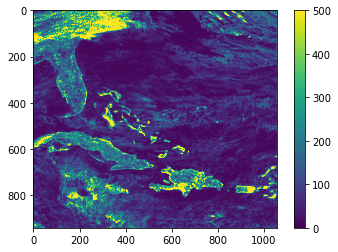

In [16]:
%%time
#calculate gradients, could use for additional cloud filtering 
rsum = R.isel(t=imax)
grad_x = rsum.differentiate("x")
grad_y = rsum.differentiate("y")
plt.imshow(np.sqrt(grad_x**2+grad_y**2),vmin=0,vmax=500)
plt.colorbar()

CPU times: user 16.7 s, sys: 701 ms, total: 17.4 s
Wall time: 16.5 s


(array([1.09293742e+01, 2.68816418e-01, 3.28429998e-01, 4.28227075e-01,
        7.10097624e-01, 1.29103198e+00, 2.57169505e+00, 2.05107422e+00,
        5.73292847e-01, 2.91155432e-01, 1.82955924e-01, 1.31191695e-01,
        1.04978052e-01, 8.26794087e-02, 4.24169802e-02, 9.80204797e-03,
        2.32229967e-03, 4.34474120e-04, 2.42225238e-05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

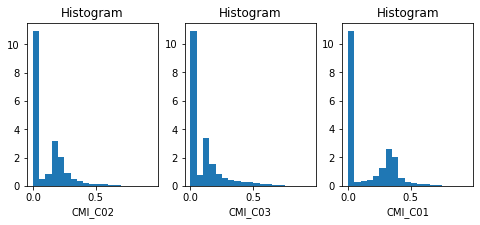

In [17]:
%%time
f, ax = plt.subplots(1, 3, figsize=(8, 3))
bins = np.arange(0,1,.05)
xr.plot.hist(R,ax=ax[0],bins=bins,density=True)
xr.plot.hist(G,ax=ax[1],bins=bins,density=True)
xr.plot.hist(B,ax=ax[2],bins=bins,density=True)